In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)


2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [5]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [6]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


In [7]:
# tf.keras.models.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.01),
              metrics = ["accuracy"])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [16]:
len(model.layers)

22

In [11]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-selu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2300 - accuracy: 0.9134 - val_loss: 0.3224 - val_accuracy: 0.8866
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2214 - accuracy: 0.9165 - val_loss: 0.3187 - val_accuracy: 0.8918
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2146 - accuracy: 0.9180 - val_loss: 0.3278 - val_accuracy: 0.8896
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2067 - accuracy: 0.9222 - val_loss: 0.3412 - val_accuracy: 0.8896
Epoch 5/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.2021 - accuracy: 0.9239 - val_loss: 0.3343 - val_accuracy: 0.8886
Epoch 6/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.1944 - accuracy: 0.9269 - val_loss: 0.3377 - val_accuracy: 0.8886
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1897 - accuracy: 0.9264 - val_loss: 0.3335 - val_accura

In [13]:
print(history.history)

{'loss': [0.23004183173179626, 0.22136369347572327, 0.21459996700286865, 0.20674680173397064, 0.2021068036556244, 0.19443029165267944, 0.18970346450805664], 'accuracy': [0.913381814956665, 0.9164727330207825, 0.9180363416671753, 0.9222363829612732, 0.923945426940918, 0.926872730255127, 0.9264181852340698], 'val_loss': [0.3223789930343628, 0.3186638355255127, 0.3277658522129059, 0.34121382236480713, 0.33426612615585327, 0.33767610788345337, 0.33350878953933716], 'val_accuracy': [0.8866000175476074, 0.8917999863624573, 0.8895999789237976, 0.8895999789237976, 0.8885999917984009, 0.8885999917984009, 0.890999972820282]}


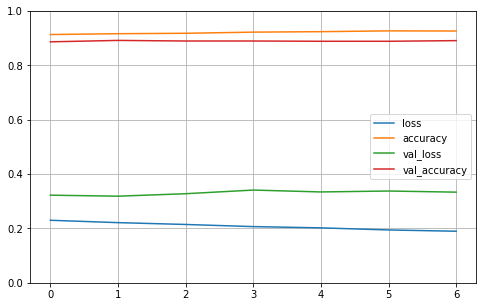

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

# 1. 参数众多，训练不充分
# 2. 梯度消失 -> 链式法则 -> 复合函数f(g(x))
#    selu缓解梯度消失

In [14]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.3712462782859802, 0.8824999928474426]